# Telco Customer Churn - Classification (Baseline + SMOTE)

I use the Kaggle Telco Customer Churn dataset and predict **Churn** as a binary classification problem.  
My goal is to build a complete pipeline: cleaning → preprocessing → training multiple classifiers → evaluation.

Because churn is the minority class, I focus on churn detection metrics:
- **Recall (Churn)**: how many churners I catch
- **F1 (Churn)**: balance between precision and recall
- **Balanced Accuracy**: accounts for class imbalance


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)


## 1) Load the dataset

I load the CSV locally after downloading it from Kaggle.


In [18]:
CSV_PATH = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(CSV_PATH)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2) Quick audit

I check dataset shape, column types, and the target distribution.


In [19]:
print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)

print("\nTarget distribution (Churn):")
print(df["Churn"].value_counts(dropna=False))

print("\nMissing values (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))


Shape: (7043, 21)

Dtypes:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Target distribution (Churn):
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Missing values (top 20):
customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
OnlineBackup        0
gender          

## 3) Cleaning

I clean the dataset by:
- removing `customerID`
- converting `TotalCharges` into numeric values
- removing duplicates
- handling missing values that appear after conversion

This step keeps the dataset consistent before modeling.


In [20]:
df_clean = df.copy()

if "customerID" in df_clean.columns:
    df_clean = df_clean.drop(columns=["customerID"])

df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")
df_clean = df_clean.drop_duplicates()

print("Shape after dropping ID and duplicates:", df_clean.shape)
print("\nMissing values after TotalCharges conversion:")
print(df_clean.isna().sum().sort_values(ascending=False).head(20))


Shape after dropping ID and duplicates: (7021, 20)

Missing values after TotalCharges conversion:
TotalCharges        11
gender               0
SeniorCitizen        0
MonthlyCharges       0
PaymentMethod        0
PaperlessBilling     0
Contract             0
StreamingMovies      0
StreamingTV          0
TechSupport          0
DeviceProtection     0
OnlineBackup         0
OnlineSecurity       0
InternetService      0
MultipleLines        0
PhoneService         0
tenure               0
Dependents           0
Partner              0
Churn                0
dtype: int64


### Step 3.1 Missing values handling

Most columns are complete. The main place missing values can appear is `TotalCharges` after conversion, because blanks become NaN.  
Even though I split features and target later, I exclude `Churn` here so it never gets modified during cleaning.


In [21]:
target_col = "Churn"

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df_clean.select_dtypes(exclude=[np.number]).columns.tolist()

if target_col in numeric_cols:
    numeric_cols.remove(target_col)
if target_col in categorical_cols:
    categorical_cols.remove(target_col)

missing_counts = df_clean.isna().sum()
num_missing_cols = [c for c in numeric_cols if missing_counts[c] > 0]
cat_missing_cols = [c for c in categorical_cols if missing_counts[c] > 0]

for c in num_missing_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())

for c in cat_missing_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].mode(dropna=True)[0])

print("Remaining missing values:")
print(df_clean.isna().sum().sort_values(ascending=False).head(20))

df_clean.head()


Remaining missing values:
gender              0
SeniorCitizen       0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
DeviceProtection    0
OnlineBackup        0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService        0
tenure              0
Dependents          0
Partner             0
Churn               0
dtype: int64


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 4) Correlation heatmap for numeric features

I visualize correlations between numeric features to spot redundancy.  
A strong correlation suggests two features may contain overlapping information.


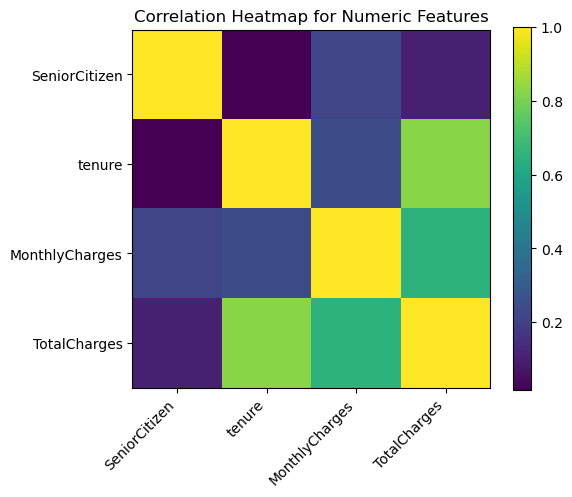

In [22]:
corr = df_clean[numeric_cols].corr()

plt.figure(figsize=(6, 5))
plt.imshow(corr, interpolation="nearest")
plt.title("Correlation Heatmap for Numeric Features")
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=45, ha="right")
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.colorbar()
plt.tight_layout()
plt.show()


## 5) Train/test split and target encoding

I separate features and target, encode `Churn` as 0/1, and create a stratified train/test split.


In [23]:
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col].map({"No": 0, "Yes": 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train churn rate:", y_train.mean(), "Test churn rate:", y_test.mean())


Train shape: (5616, 19) Test shape: (1405, 19)
Train churn rate: 0.2644230769230769 Test churn rate: 0.26476868327402137


## 6) Preprocessing pipeline

I preprocess numeric and categorical features with a `ColumnTransformer`:
- numeric: impute median + standardize
- categorical: impute most frequent + one-hot encode

Using a pipeline prevents leakage and keeps preprocessing consistent.


In [24]:
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_features),
        ("cat", cat_pipe, cat_features),
    ],
    remainder="drop"
)


## 7) Models

I train a small set of standard classifiers to compare performance across model families.


In [25]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "SVM_RBF": SVC(kernel="rbf"),
    "DecisionTree": DecisionTreeClassifier(max_depth=6, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=400, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=15),
    "GaussianNB": GaussianNB(),
}


## 8) Baseline test-set evaluation (metrics + confusion matrices)

I evaluate each model on the test set and record multiple metrics.  
Because churn is the minority class, I focus on:
- churn recall
- churn F1
- balanced accuracy

I also plot confusion matrices to see false negatives directly.



=== LogisticRegression (Baseline) ===
Accuracy: 0.8028 | Balanced Acc: 0.7137 | Precision: 0.6610 | Recall: 0.5242 | F1: 0.5847
              precision    recall  f1-score   support

           0     0.8405    0.9032    0.8707      1033
           1     0.6610    0.5242    0.5847       372

    accuracy                         0.8028      1405
   macro avg     0.7508    0.7137    0.7277      1405
weighted avg     0.7930    0.8028    0.7950      1405



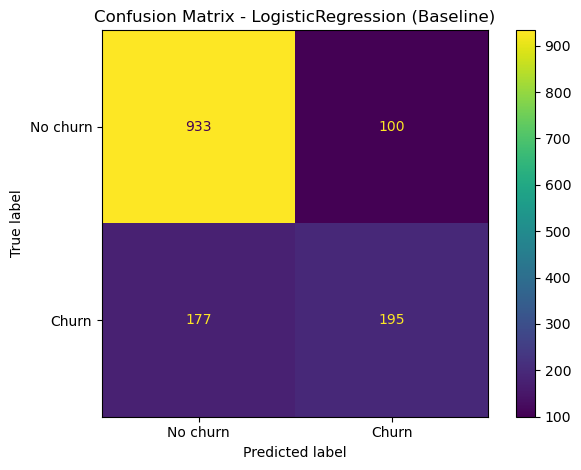


=== SVM_RBF (Baseline) ===
Accuracy: 0.7986 | Balanced Acc: 0.6987 | Precision: 0.6630 | Recall: 0.4866 | F1: 0.5612
              precision    recall  f1-score   support

           0     0.8313    0.9109    0.8693      1033
           1     0.6630    0.4866    0.5612       372

    accuracy                         0.7986      1405
   macro avg     0.7471    0.6987    0.7153      1405
weighted avg     0.7867    0.7986    0.7877      1405



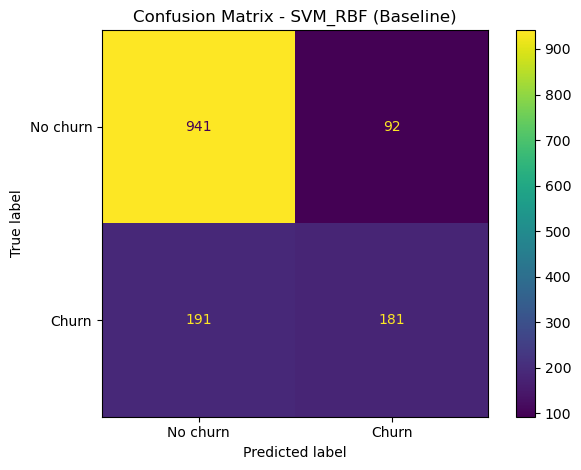


=== DecisionTree (Baseline) ===
Accuracy: 0.7936 | Balanced Acc: 0.7014 | Precision: 0.6395 | Recall: 0.5054 | F1: 0.5646
              precision    recall  f1-score   support

           0     0.8344    0.8974    0.8647      1033
           1     0.6395    0.5054    0.5646       372

    accuracy                         0.7936      1405
   macro avg     0.7369    0.7014    0.7147      1405
weighted avg     0.7828    0.7936    0.7853      1405



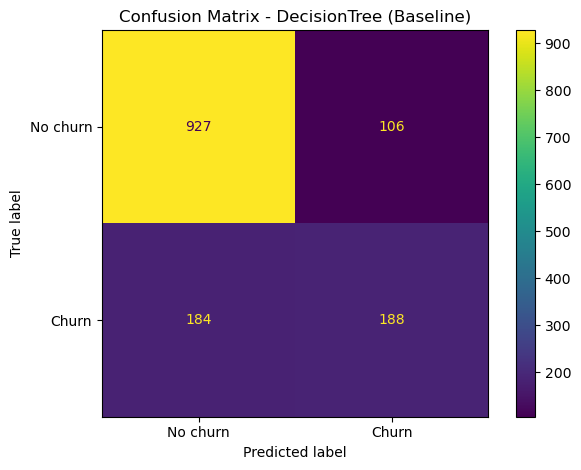


=== RandomForest (Baseline) ===
Accuracy: 0.7786 | Balanced Acc: 0.6732 | Precision: 0.6117 | Recall: 0.4489 | F1: 0.5178
              precision    recall  f1-score   support

           0     0.8189    0.8974    0.8564      1033
           1     0.6117    0.4489    0.5178       372

    accuracy                         0.7786      1405
   macro avg     0.7153    0.6732    0.6871      1405
weighted avg     0.7640    0.7786    0.7667      1405



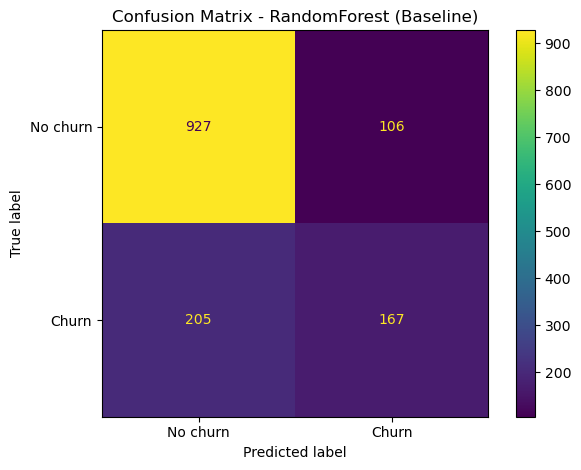


=== KNN (Baseline) ===
Accuracy: 0.7851 | Balanced Acc: 0.7068 | Precision: 0.6054 | Recall: 0.5403 | F1: 0.5710
              precision    recall  f1-score   support

           0     0.8406    0.8732    0.8566      1033
           1     0.6054    0.5403    0.5710       372

    accuracy                         0.7851      1405
   macro avg     0.7230    0.7068    0.7138      1405
weighted avg     0.7784    0.7851    0.7810      1405



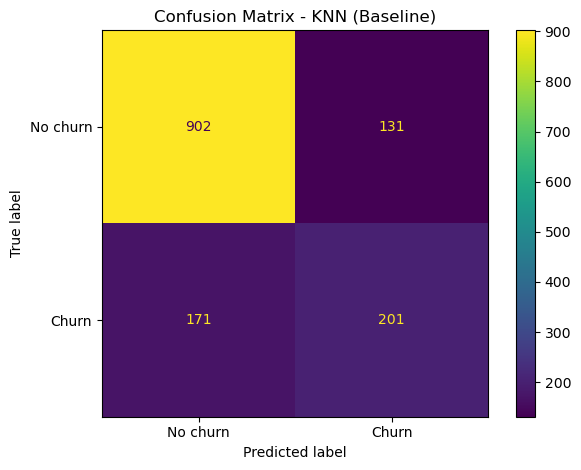


=== GaussianNB (Baseline) ===
Accuracy: 0.6861 | Balanced Acc: 0.7341 | Precision: 0.4501 | Recall: 0.8360 | F1: 0.5851
              precision    recall  f1-score   support

           0     0.9146    0.6321    0.7476      1033
           1     0.4501    0.8360    0.5851       372

    accuracy                         0.6861      1405
   macro avg     0.6823    0.7341    0.6664      1405
weighted avg     0.7916    0.6861    0.7046      1405



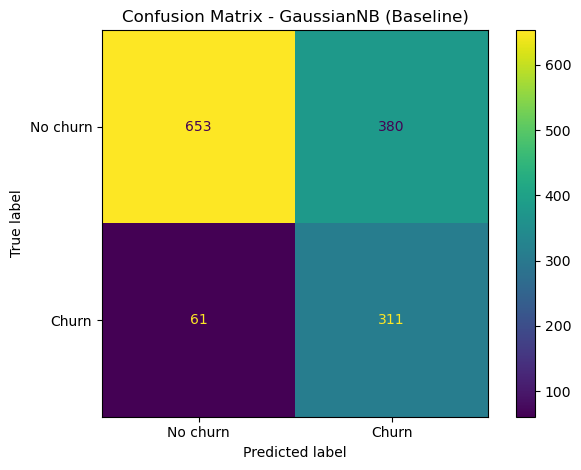

,Model,Accuracy,Balanced Acc,Precision (Churn),Recall (Churn),F1 (Churn)
0,GaussianNB,0.686121,0.734080,0.450072,0.836022,0.585136
1,KNN,0.785053,0.706754,0.605422,0.540323,0.571023
2,LogisticRegression,0.802847,0.713694,0.661017,0.524194,0.584708
3,DecisionTree,0.793594,0.701381,0.639456,0.505376,0.564565
4,SVM_RBF,0.798577,0.698749,0.663004,0.486559,0.561240
5,RandomForest,0.778648,0.673155,0.611722,0.448925,0.517829


In [26]:
baseline_rows = []

for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("model", clf)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    acc = accuracy_score(y_test, preds)
    bal_acc = balanced_accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, pos_label=1)
    rec = recall_score(y_test, preds, pos_label=1)
    f1 = f1_score(y_test, preds, pos_label=1)

    baseline_rows.append((name, acc, bal_acc, prec, rec, f1))

    print(f"\n=== {name} (Baseline) ===")
    print(f"Accuracy: {acc:.4f} | Balanced Acc: {bal_acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print(classification_report(y_test, preds, digits=4))

    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No churn", "Churn"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix - {name} (Baseline)")
    plt.tight_layout()
    plt.show()

baseline_df = (
    pd.DataFrame(
        baseline_rows,
        columns=["Model", "Accuracy", "Balanced Acc", "Precision (Churn)", "Recall (Churn)", "F1 (Churn)"]
    )
    .sort_values("Recall (Churn)", ascending=False)
    .reset_index(drop=True)
)

baseline_df


### 8.1 Baseline bar charts for churn detection

I plot churn recall and churn F1 so improvements in finding churners are easy to see.


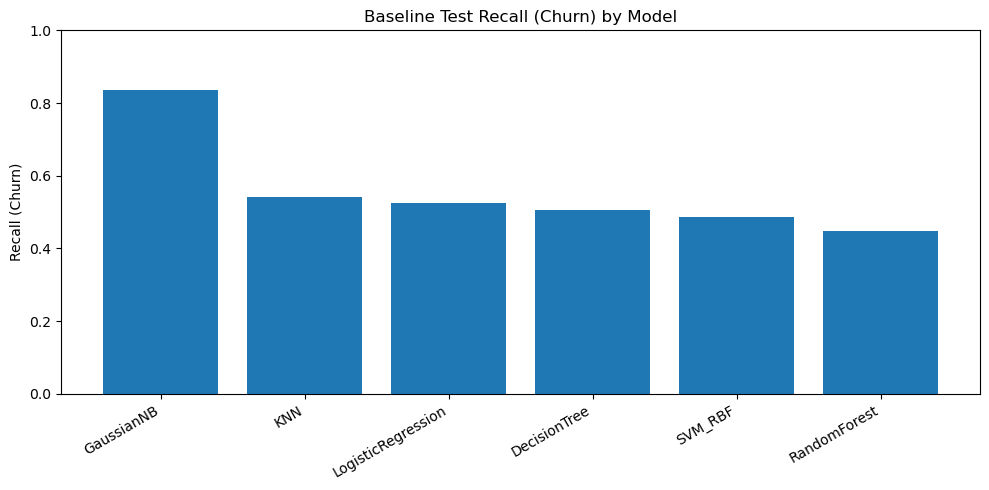

In [27]:
plt.figure(figsize=(10, 5))
plt.bar(baseline_df["Model"], baseline_df["Recall (Churn)"])
plt.ylabel("Recall (Churn)")
plt.title("Baseline Test Recall (Churn) by Model")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


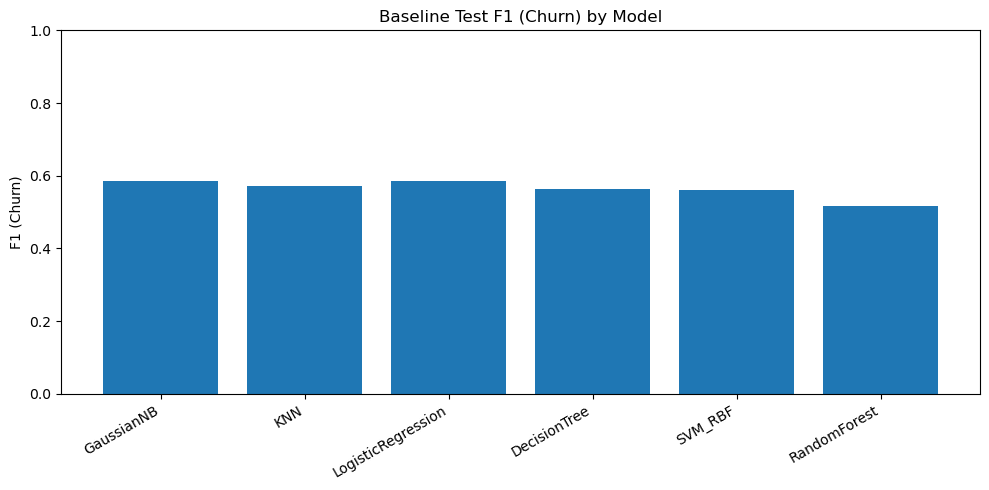

In [28]:
plt.figure(figsize=(10, 5))
plt.bar(baseline_df["Model"], baseline_df["F1 (Churn)"])
plt.ylabel("F1 (Churn)")
plt.title("Baseline Test F1 (Churn) by Model")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


## 9) Baseline cross-validation (churn-focused)

I use stratified 5-fold cross-validation to confirm performance is not dependent on a single split.  
I report the mean and standard deviation across folds for:
- accuracy
- balanced accuracy
- churn recall
- churn F1


In [29]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_rows_baseline = []
for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("model", clf)])

    acc_scores = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
    bal_scores = cross_val_score(pipe, X, y, cv=cv, scoring="balanced_accuracy")
    rec_scores = cross_val_score(pipe, X, y, cv=cv, scoring="recall")
    f1_scores  = cross_val_score(pipe, X, y, cv=cv, scoring="f1")

    cv_rows_baseline.append((
        name,
        acc_scores.mean(), acc_scores.std(),
        bal_scores.mean(), bal_scores.std(),
        rec_scores.mean(), rec_scores.std(),
        f1_scores.mean(),  f1_scores.std()
    ))

cv_baseline_df = (
    pd.DataFrame(
        cv_rows_baseline,
        columns=[
            "Model",
            "CV Acc mean", "CV Acc std",
            "CV BalAcc mean", "CV BalAcc std",
            "CV Recall mean", "CV Recall std",
            "CV F1 mean", "CV F1 std"
        ]
    )
    .sort_values("CV Recall mean", ascending=False)
    .reset_index(drop=True)
)

cv_baseline_df


,Model,CV Acc mean,CV Acc std,CV BalAcc mean,CV BalAcc std,CV Recall mean,CV Recall std,CV F1 mean,CV F1 std
0,GaussianNB,0.693064,0.018619,0.742212,0.014602,0.846539,0.022045,0.593584,0.015857
1,KNN,0.787207,0.011271,0.715677,0.012692,0.563807,0.020157,0.583659,0.019465
2,LogisticRegression,0.803018,0.008041,0.720390,0.010130,0.544961,0.018486,0.594027,0.015919
3,DecisionTree,0.788347,0.010308,0.700754,0.014225,0.514794,0.025396,0.562531,0.022870
4,SVM_RBF,0.799030,0.007530,0.697674,0.010052,0.482487,0.020400,0.559346,0.017223
5,RandomForest,0.787920,0.009740,0.689606,0.009348,0.480877,0.013247,0.545459,0.015973


### 9.1 Baseline cross-validation bar charts

I plot cross-validated churn recall and churn F1 to compare models more reliably.


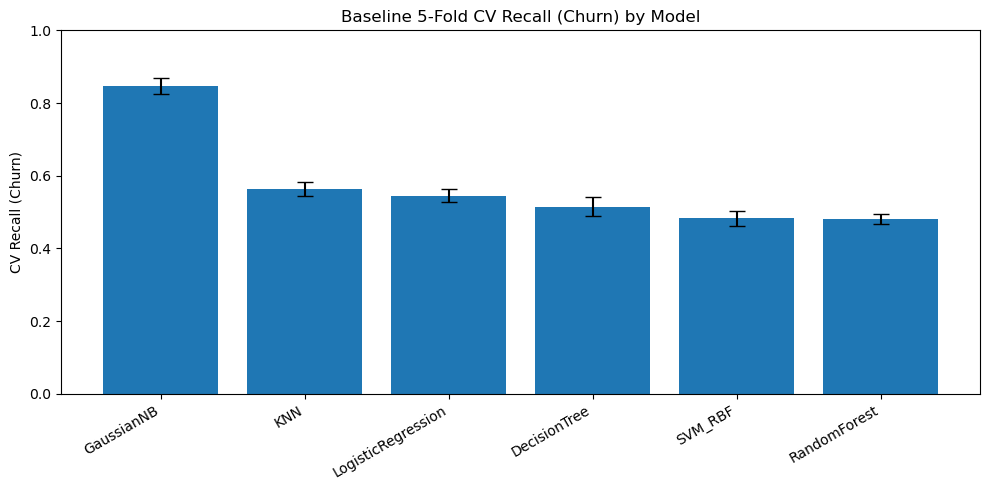

In [30]:
plt.figure(figsize=(10, 5))
plt.bar(cv_baseline_df["Model"], cv_baseline_df["CV Recall mean"], yerr=cv_baseline_df["CV Recall std"], capsize=6)
plt.ylabel("CV Recall (Churn)")
plt.title("Baseline 5-Fold CV Recall (Churn) by Model")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


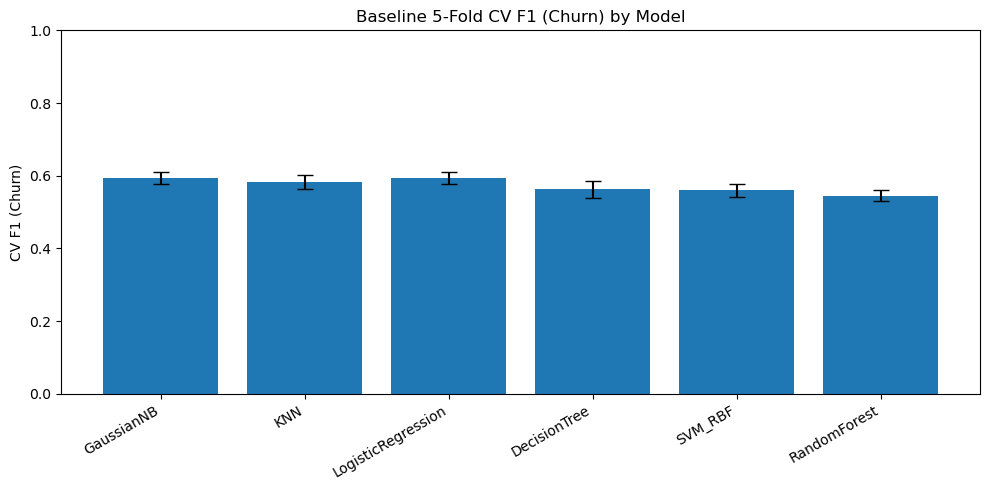

In [31]:
plt.figure(figsize=(10, 5))
plt.bar(cv_baseline_df["Model"], cv_baseline_df["CV F1 mean"], yerr=cv_baseline_df["CV F1 std"], capsize=6)
plt.ylabel("CV F1 (Churn)")
plt.title("Baseline 5-Fold CV F1 (Churn) by Model")
plt.xticks(rotation=30, ha="right")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


## 10) Rebalancing with SMOTE (test-set + cross-validation)

Churn is the minority class, so I rebalance only the training data using SMOTE.  
I keep the test set untouched so evaluation remains fair.

I compare baseline vs SMOTE using churn recall, churn F1, and confusion matrices.


In [32]:
# Run this once if needed:
# pip install imbalanced-learn

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


### 10.1 SMOTE test-set evaluation



=== LogisticRegression (SMOTE) ===
Accuracy: 0.7488 | Balanced Acc: 0.7535 | Precision: 0.5173 | Recall: 0.7634 | F1: 0.6167
              precision    recall  f1-score   support

           0     0.8972    0.7435    0.8131      1033
           1     0.5173    0.7634    0.6167       372

    accuracy                         0.7488      1405
   macro avg     0.7073    0.7535    0.7149      1405
weighted avg     0.7966    0.7488    0.7611      1405



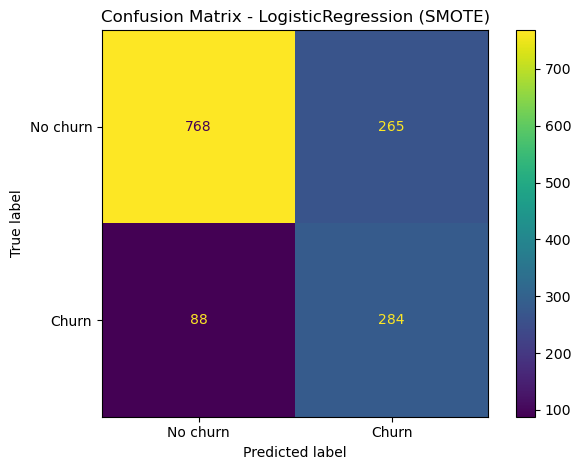


=== SVM_RBF (SMOTE) ===
Accuracy: 0.7744 | Balanced Acc: 0.7485 | Precision: 0.5597 | Recall: 0.6935 | F1: 0.6194
              precision    recall  f1-score   support

           0     0.8792    0.8035    0.8397      1033
           1     0.5597    0.6935    0.6194       372

    accuracy                         0.7744      1405
   macro avg     0.7194    0.7485    0.7296      1405
weighted avg     0.7946    0.7744    0.7814      1405



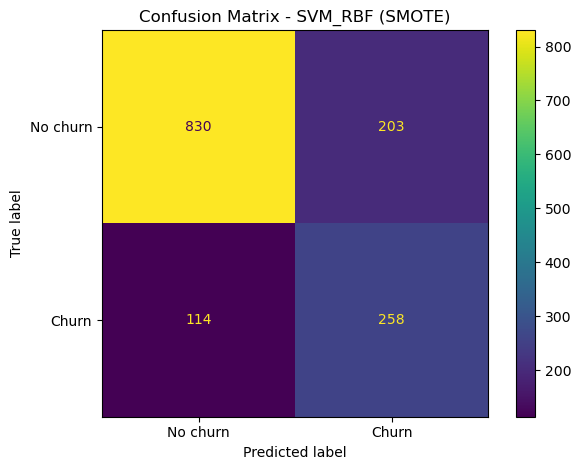


=== DecisionTree (SMOTE) ===
Accuracy: 0.7580 | Balanced Acc: 0.7425 | Precision: 0.5323 | Recall: 0.7097 | F1: 0.6083
              precision    recall  f1-score   support

           0     0.8812    0.7754    0.8249      1033
           1     0.5323    0.7097    0.6083       372

    accuracy                         0.7580      1405
   macro avg     0.7067    0.7425    0.7166      1405
weighted avg     0.7888    0.7580    0.7676      1405



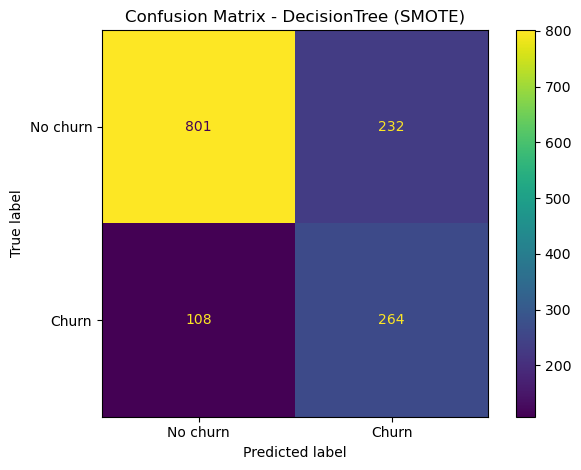


=== RandomForest (SMOTE) ===
Accuracy: 0.7730 | Balanced Acc: 0.6942 | Precision: 0.5782 | Recall: 0.5269 | F1: 0.5513
              precision    recall  f1-score   support

           0     0.8349    0.8616    0.8480      1033
           1     0.5782    0.5269    0.5513       372

    accuracy                         0.7730      1405
   macro avg     0.7065    0.6942    0.6997      1405
weighted avg     0.7669    0.7730    0.7695      1405



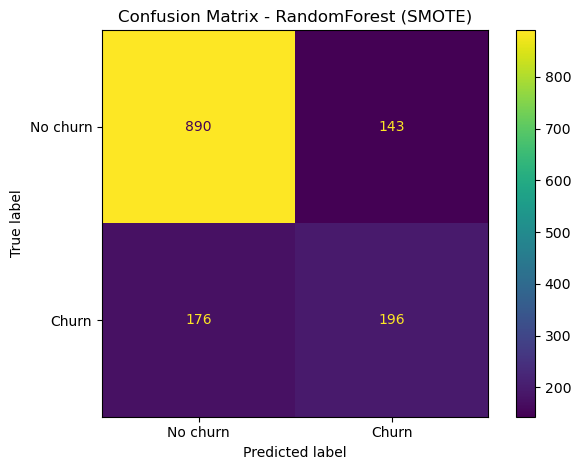


=== KNN (SMOTE) ===
Accuracy: 0.7060 | Balanced Acc: 0.7399 | Precision: 0.4682 | Recall: 0.8118 | F1: 0.5939
              precision    recall  f1-score   support

           0     0.9079    0.6680    0.7697      1033
           1     0.4682    0.8118    0.5939       372

    accuracy                         0.7060      1405
   macro avg     0.6881    0.7399    0.6818      1405
weighted avg     0.7915    0.7060    0.7231      1405



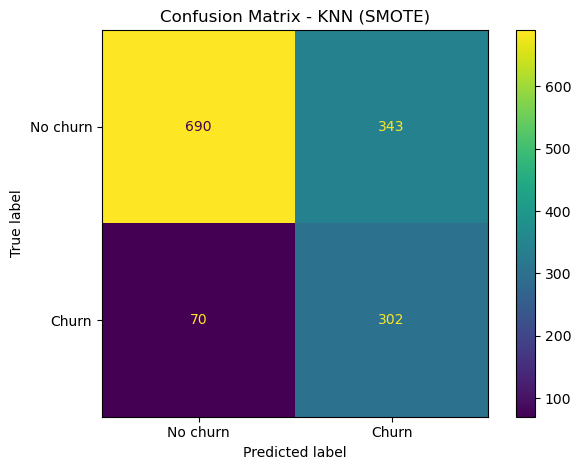


=== GaussianNB (SMOTE) ===
Accuracy: 0.6996 | Balanced Acc: 0.7416 | Precision: 0.4626 | Recall: 0.8306 | F1: 0.5942
              precision    recall  f1-score   support

           0     0.9145    0.6525    0.7616      1033
           1     0.4626    0.8306    0.5942       372

    accuracy                         0.6996      1405
   macro avg     0.6885    0.7416    0.6779      1405
weighted avg     0.7949    0.6996    0.7173      1405



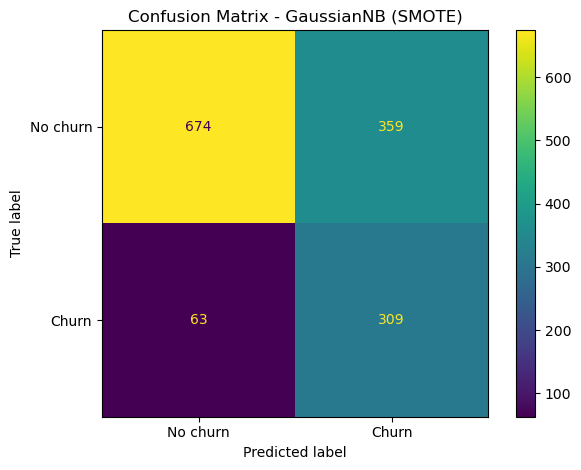

,Model,Accuracy,Balanced Acc,Precision (Churn),Recall (Churn),F1 (Churn)
0,GaussianNB,0.699644,0.741557,0.462575,0.830645,0.594231
1,KNN,0.706050,0.739893,0.468217,0.811828,0.593904
2,LogisticRegression,0.748754,0.753453,0.517304,0.763441,0.616721
3,DecisionTree,0.758007,0.742544,0.532258,0.709677,0.608295
4,SVM_RBF,0.774377,0.748517,0.559653,0.693548,0.619448
5,RandomForest,0.772954,0.694225,0.578171,0.526882,0.551336


In [33]:
smote_rows = []

for name, clf in models.items():
    pipe_smote = ImbPipeline(steps=[
        ("prep", preprocess),
        ("smote", SMOTE(random_state=42)),
        ("model", clf)
    ])

    pipe_smote.fit(X_train, y_train)
    preds = pipe_smote.predict(X_test)

    acc = accuracy_score(y_test, preds)
    bal_acc = balanced_accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, pos_label=1)
    rec = recall_score(y_test, preds, pos_label=1)
    f1 = f1_score(y_test, preds, pos_label=1)

    smote_rows.append((name, acc, bal_acc, prec, rec, f1))

    print(f"\n=== {name} (SMOTE) ===")
    print(f"Accuracy: {acc:.4f} | Balanced Acc: {bal_acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print(classification_report(y_test, preds, digits=4))

    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No churn", "Churn"])
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix - {name} (SMOTE)")
    plt.tight_layout()
    plt.show()

smote_df = (
    pd.DataFrame(
        smote_rows,
        columns=["Model", "Accuracy", "Balanced Acc", "Precision (Churn)", "Recall (Churn)", "F1 (Churn)"]
    )
    .sort_values("Recall (Churn)", ascending=False)
    .reset_index(drop=True)
)

smote_df


### 10.2 Baseline vs SMOTE comparison table and bar charts


In [34]:
compare_df = baseline_df.merge(smote_df, on="Model", suffixes=(" Baseline", " SMOTE"))
compare_df


,Model,Accuracy Baseline,Balanced Acc Baseline,Precision (Churn) Baseline,Recall (Churn) Baseline,F1 (Churn) Baseline,Accuracy SMOTE,Balanced Acc SMOTE,Precision (Churn) SMOTE,Recall (Churn) SMOTE,F1 (Churn) SMOTE
0,GaussianNB,0.686121,0.734080,0.450072,0.836022,0.585136,0.699644,0.741557,0.462575,0.830645,0.594231
1,KNN,0.785053,0.706754,0.605422,0.540323,0.571023,0.706050,0.739893,0.468217,0.811828,0.593904
2,LogisticRegression,0.802847,0.713694,0.661017,0.524194,0.584708,0.748754,0.753453,0.517304,0.763441,0.616721
3,DecisionTree,0.793594,0.701381,0.639456,0.505376,0.564565,0.758007,0.742544,0.532258,0.709677,0.608295
4,SVM_RBF,0.798577,0.698749,0.663004,0.486559,0.561240,0.774377,0.748517,0.559653,0.693548,0.619448
5,RandomForest,0.778648,0.673155,0.611722,0.448925,0.517829,0.772954,0.694225,0.578171,0.526882,0.551336


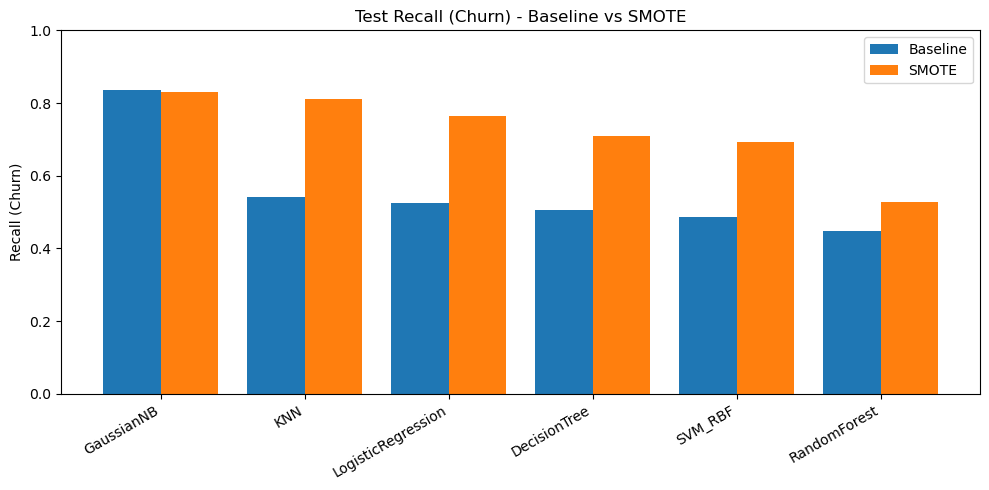

In [36]:
compare_sorted = compare_df.sort_values("Recall (Churn) Baseline", ascending=False)

plt.figure(figsize=(10, 5))
x = np.arange(len(compare_sorted["Model"]))
width = 0.4

plt.bar(x - width/2, compare_sorted["Recall (Churn) Baseline"], width, label="Baseline")
plt.bar(x + width/2, compare_sorted["Recall (Churn) SMOTE"], width, label="SMOTE")

plt.ylabel("Recall (Churn)")
plt.title("Test Recall (Churn) - Baseline vs SMOTE")
plt.xticks(x, compare_sorted["Model"], rotation=30, ha="right")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


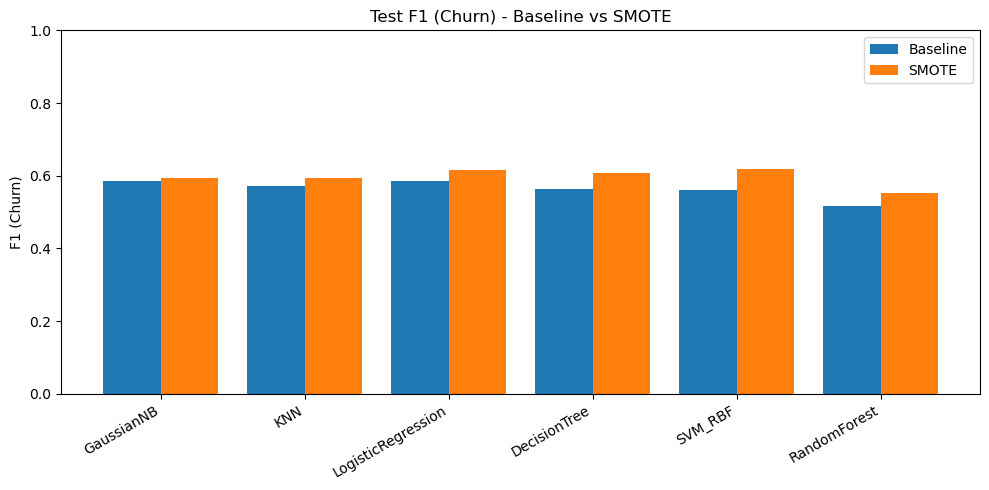

In [37]:
plt.figure(figsize=(10, 5))
x = np.arange(len(compare_sorted["Model"]))
width = 0.4

plt.bar(x - width/2, compare_sorted["F1 (Churn) Baseline"], width, label="Baseline")
plt.bar(x + width/2, compare_sorted["F1 (Churn) SMOTE"], width, label="SMOTE")

plt.ylabel("F1 (Churn)")
plt.title("Test F1 (Churn) - Baseline vs SMOTE")
plt.xticks(x, compare_sorted["Model"], rotation=30, ha="right")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


### 10.3 SMOTE cross-validation

I apply SMOTE inside the pipeline so oversampling happens only within the training folds.


In [38]:
cv_rows_smote = []
for name, clf in models.items():
    pipe_smote = ImbPipeline(steps=[
        ("prep", preprocess),
        ("smote", SMOTE(random_state=42)),
        ("model", clf)
    ])

    acc_scores = cross_val_score(pipe_smote, X, y, cv=cv, scoring="accuracy")
    bal_scores = cross_val_score(pipe_smote, X, y, cv=cv, scoring="balanced_accuracy")
    rec_scores = cross_val_score(pipe_smote, X, y, cv=cv, scoring="recall")
    f1_scores  = cross_val_score(pipe_smote, X, y, cv=cv, scoring="f1")

    cv_rows_smote.append((
        name,
        acc_scores.mean(), acc_scores.std(),
        bal_scores.mean(), bal_scores.std(),
        rec_scores.mean(), rec_scores.std(),
        f1_scores.mean(),  f1_scores.std()
    ))

cv_smote_df = (
    pd.DataFrame(
        cv_rows_smote,
        columns=[
            "Model",
            "CV Acc mean", "CV Acc std",
            "CV BalAcc mean", "CV BalAcc std",
            "CV Recall mean", "CV Recall std",
            "CV F1 mean", "CV F1 std"
        ]
    )
    .sort_values("CV Recall mean", ascending=False)
    .reset_index(drop=True)
)

cv_smote_df


,Model,CV Acc mean,CV Acc std,CV BalAcc mean,CV BalAcc std,CV Recall mean,CV Recall std,CV F1 mean,CV F1 std
0,GaussianNB,0.703033,0.016335,0.746230,0.013945,0.837923,0.023838,0.598978,0.015210
1,KNN,0.696340,0.009175,0.738220,0.010389,0.827134,0.020571,0.590305,0.010830
2,LogisticRegression,0.754878,0.009897,0.768535,0.011662,0.797523,0.020104,0.632510,0.013624
3,SVM_RBF,0.765275,0.010716,0.753015,0.013715,0.726980,0.025643,0.620926,0.016839
4,DecisionTree,0.762427,0.007555,0.744359,0.010479,0.705988,0.021500,0.611126,0.012760
5,RandomForest,0.780230,0.009037,0.708174,0.008571,0.555194,0.012997,0.572065,0.013344


### 10.4 Cross-validation comparison charts (Baseline vs SMOTE)


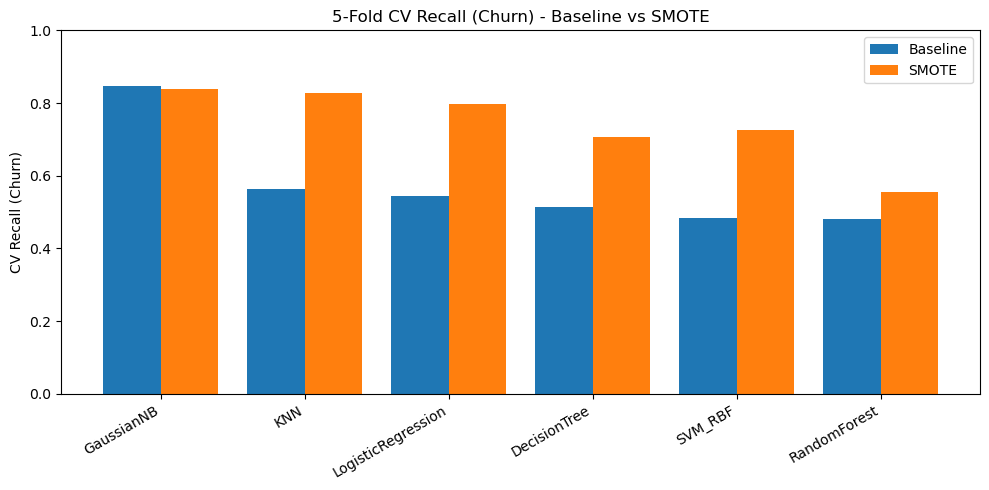

In [39]:
cv_compare_df = cv_baseline_df.merge(cv_smote_df, on="Model", suffixes=(" Baseline", " SMOTE"))
cv_compare_sorted = cv_compare_df.sort_values("CV Recall mean Baseline", ascending=False)

plt.figure(figsize=(10, 5))
x = np.arange(len(cv_compare_sorted["Model"]))
width = 0.4

plt.bar(x - width/2, cv_compare_sorted["CV Recall mean Baseline"], width, label="Baseline")
plt.bar(x + width/2, cv_compare_sorted["CV Recall mean SMOTE"], width, label="SMOTE")

plt.ylabel("CV Recall (Churn)")
plt.title("5-Fold CV Recall (Churn) - Baseline vs SMOTE")
plt.xticks(x, cv_compare_sorted["Model"], rotation=30, ha="right")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


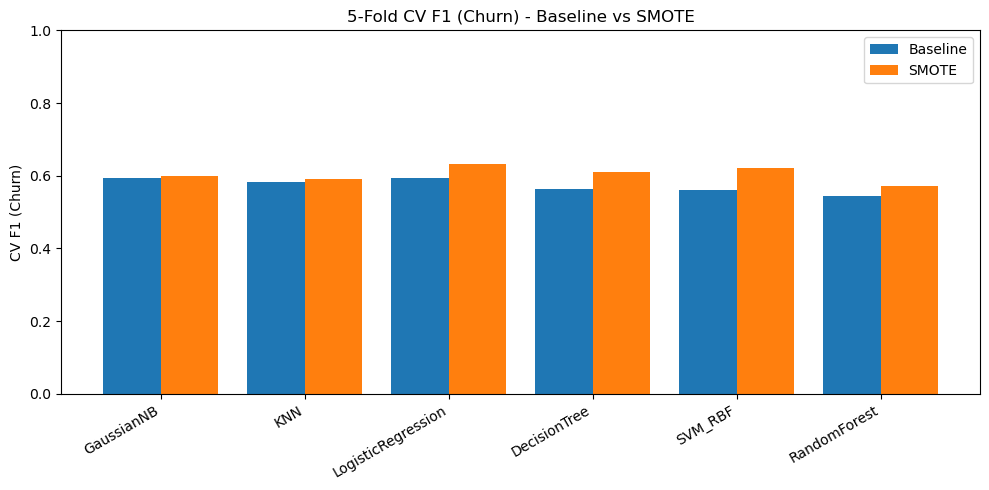

In [40]:
plt.figure(figsize=(10, 5))
x = np.arange(len(cv_compare_sorted["Model"]))
width = 0.4

plt.bar(x - width/2, cv_compare_sorted["CV F1 mean Baseline"], width, label="Baseline")
plt.bar(x + width/2, cv_compare_sorted["CV F1 mean SMOTE"], width, label="SMOTE")

plt.ylabel("CV F1 (Churn)")
plt.title("5-Fold CV F1 (Churn) - Baseline vs SMOTE")
plt.xticks(x, cv_compare_sorted["Model"], rotation=30, ha="right")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()
